**Step 1: Import Library**

In [1]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.6 MB/s eta 0:00:00


In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
from art.attacks.evasion import DeepFool
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier
from art.defences.trainer import AdversarialTrainer
from art.defences.preprocessor import FeatureSqueezing

**Step 2: Load and Preprocess the Dataset**

In [3]:
# 1. Load and preprocess the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Reshape data for the model input
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
# Split into training, validation, and testing sets
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

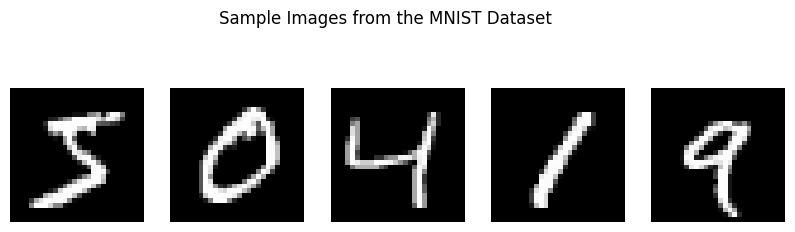

In [6]:
# Visualize sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(x_train[i].reshape(28, 28), cmap='gray')
    axes[i].axis('off')
plt.suptitle("Sample Images from the MNIST Dataset")
plt.show()

**Step 3: Build and Train a CNN Model**

In [7]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model and save the training history
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 59ms/step - accuracy: 0.8897 - loss: 0.3909 - val_accuracy: 0.9765 - val_loss: 0.0807
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 37ms/step - accuracy: 0.9795 - loss: 0.0684 - val_accuracy: 0.9831 - val_loss: 0.0641
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9883 - loss: 0.0388 - val_accuracy: 0.9833 - val_loss: 0.0564
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9916 - loss: 0.0279 - val_accuracy: 0.9825 - val_loss: 0.0567
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.9942 - loss: 0.0185 - val_accuracy: 0.9838 - val_loss: 0.0554


In [10]:
# Evaluate the model on clean test data
clean_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Model accuracy on clean test data: {clean_accuracy[1]:.4f}")

Model accuracy on clean test data: 0.9839


**Step 4: Visualize Training Progress**

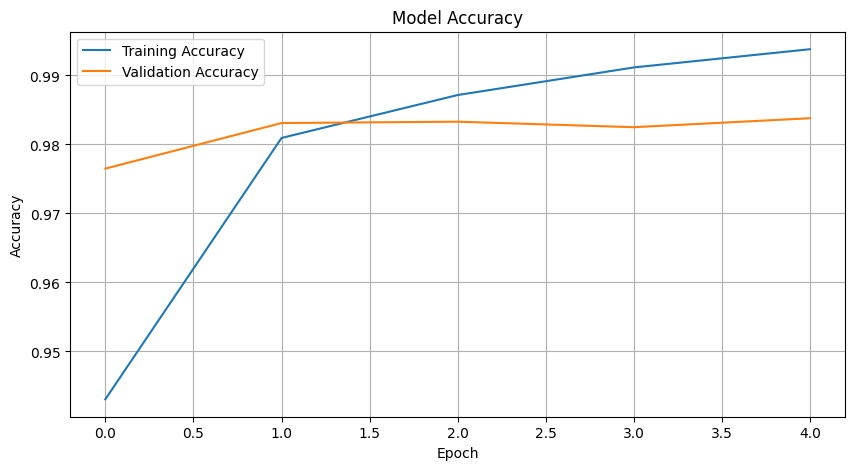

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Step 5: Generate Adversarial Examples using FGSM and PGD**

In [12]:
# Create a TensorFlowV2Classifier for the ART library
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy()
)

In [13]:
# Generate adversarial examples using FGSM
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv_fgsm = fgsm_attack.generate(x=x_test)

# Generate adversarial examples using PGD
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.1)
x_test_adv_pgd = pgd_attack.generate(x=x_test)

PGD - Batches: 0it [00:00, ?it/s]

In [14]:
# Evaluate the model on adversarial examples
fgsm_accuracy = model.evaluate(x_test_adv_fgsm, y_test, verbose=0)
pgd_accuracy = model.evaluate(x_test_adv_pgd, y_test, verbose=0)
print(f"Model accuracy on FGSM adversarial data: {fgsm_accuracy[1]:.4f}")
print(f"Model accuracy on PGD adversarial data: {pgd_accuracy[1]:.4f}")

Model accuracy on FGSM adversarial data: 0.4432
Model accuracy on PGD adversarial data: 0.0216


**Step 6: Data Poisoning - Inject Adversarial Examples into Training Set**

In [15]:
# Generate adversarial examples from the training set using FGSM
x_train_adv = fgsm_attack.generate(x=x_train)

# Create a poisoned training set by combining original and adversarial examples
x_train_poisoned = np.concatenate((x_train, x_train_adv))
y_train_poisoned = np.concatenate((y_train, y_train))

In [ ]:
# Retrain the model on poisoned training data
model_poisoned = tf.keras.models.clone_model(model)
model_poisoned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_poisoned.fit(x_train_poisoned, y_train_poisoned, epochs=5, batch_size=64)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 35ms/step - accuracy: 0.9276 - loss: 0.2602
Epoch 2/5
   1/1563 ━━━━━━━━━━━━━━━━━━━━ 11:33:25 27s/step - accuracy: 0.9688 - loss: 0.1440

In [ ]:
# Evaluate the model on clean and poisoned test data
clean_accuracy_poisoned = model_poisoned.evaluate(x_test, y_test, verbose=0)
fgsm_accuracy_poisoned = model_poisoned.evaluate(x_test_adv_fgsm, y_test, verbose=0)
print(f"Poisoned model accuracy on clean test data: {clean_accuracy_poisoned[1]:.4f}")
print(f"Poisoned model accuracy on FGSM adversarial data: {fgsm_accuracy_poisoned[1]:.4f}")

**Step 7: Apply Defense - Adversarial Training**

In [ ]:
# Apply adversarial training as a defense mechanism
trainer = AdversarialTrainer(classifier, attacks=[fgsm_attack], ratio=0.5)
trainer.fit(x_train, y_train, nb_epochs=5, batch_size=64))

In [22]:
# Evaluate the defended model on clean and adversarial data
# Get predictions for clean, FGSM, and PGD test sets
y_pred_clean = trainer.get_classifier().predict(x_test)
y_pred_fgsm = trainer.get_classifier().predict(x_test_adv_fgsm)
y_pred_pgd = trainer.get_classifier().predict(x_test_adv_pgd)

In [23]:
# Convert one-hot encoded labels back to integers
y_test_labels = np.argmax(y_test, axis=1)

In [31]:
# 3. Calculate accuracy for each set
defended_accuracy_clean = accuracy_score(y_test_labels, np.argmax(y_pred_clean, axis=1))
defended_accuracy_fgsm = accuracy_score(y_test_labels, np.argmax(y_pred_fgsm, axis=1))
defended_accuracy_pgd = accuracy_score(y_test_labels, np.argmax(y_pred_pgd, axis=1))

print(f"Defended model accuracy on clean test data: {defended_accuracy_clean:.4f}")
print(f"Defended model accuracy on FGSM adversarial data: {defended_accuracy_fgsm:.4f}")
print(f"Defended model accuracy on PGD adversarial data: {defended_accuracy_pgd:.4f}")

Defended model accuracy on clean test data: 0.9839
Defended model accuracy on FGSM adversarial data: 0.4432
Defended model accuracy on PGD adversarial data: 0.0216


**Step 8: Evaluate the Model Using DeepFool Attack**

In [32]:
# Limit the test set size for faster processing
subset_size = 200  # Adjust the subset size to reduce computation time
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# Initialize DeepFool with fewer iterations for faster processing
classifier = trainer.get_classifier()  # Get the classifier from the AdversarialTrainer
deepfool_attack = DeepFool(classifier=classifier, max_iter=10)  # Reduce iterations

# Generate adversarial examples using DeepFool
x_test_adv_deepfool = deepfool_attack.generate(x=x_test_subset, batch_size=32)  # Use batch processing

DeepFool:   0%|          | 0/200 [00:00<?, ?it/s]

In [33]:
# Get predictions for DeepFool adversarial examples
y_pred_deepfool = classifier.predict(x_test_adv_deepfool)

# Convert one-hot encoded labels back to integers
y_test_labels = np.argmax(y_test_subset, axis=1)

In [34]:
# Calculate accuracy for DeepFool adversarial examples
deepfool_accuracy = accuracy_score(y_test_labels, np.argmax(y_pred_deepfool, axis=1))
print(f"Defended model accuracy on DeepFool adversarial data (subset): {deepfool_accuracy:.4f}")

Defended model accuracy on DeepFool adversarial data (subset): 0.1500


**Step 9: Visualize Clean vs Adversarial Examples**

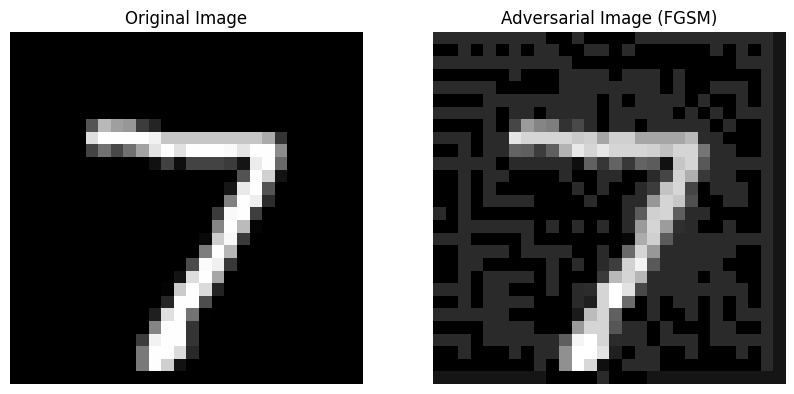

In [35]:
# Original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.axis('off')

# Adversarial image (FGSM)
plt.subplot(1, 2, 2)
plt.title("Adversarial Image (FGSM)")
plt.imshow(x_test_adv_fgsm[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

**Step 10: Summary of Results**

In [40]:
# Print the original model's accuracy on clean and adversarial data
print("\n--- Final Results ---")

# Accuracy on clean test data using the original model
print(f"Clean Accuracy (Original): {clean_accuracy[1]:.4f}")

# Accuracy on FGSM adversarial examples using the original model
print(f"FGSM Accuracy (Original): {fgsm_accuracy[1]:.4f}")

# Accuracy on PGD adversarial examples using the original model
print(f"PGD Accuracy (Original): {pgd_accuracy[1]:.4f}")


--- Final Results ---
Clean Accuracy (Original): 0.9839
FGSM Accuracy (Original): 0.4432
PGD Accuracy (Original): 0.0216


In [41]:
# Print the defended model's accuracy after applying adversarial training
# Accuracy on clean test data using the defended model
print(f"Clean Accuracy (Defended): {defended_accuracy_clean:.4f}")

# Accuracy on FGSM adversarial examples using the defended model
print(f"FGSM Accuracy (Defended): {defended_accuracy_fgsm:.4f}")

# Accuracy on PGD adversarial examples using the defended model
print(f"PGD Accuracy (Defended): {defended_accuracy_pgd:.4f}")

# Accuracy on DeepFool adversarial examples using the defended model
print(f"DeepFool Accuracy (Defended): {deepfool_accuracy:.4f}")

Clean Accuracy (Defended): 0.9839
FGSM Accuracy (Defended): 0.4432
PGD Accuracy (Defended): 0.0216
DeepFool Accuracy (Defended): 0.1500


**Step 11: Visualizing and Summarizing Results**

In [44]:
# Accuracy values for original and defended models
original_accuracies = [clean_accuracy[1], fgsm_accuracy[1], pgd_accuracy[1]]
defended_accuracies = [defended_accuracy_clean, defended_accuracy_fgsm, defended_accuracy_pgd, deepfool_accuracy]

# Add placeholder for DeepFool in original model if it's not available
if len(original_accuracies) < len(defended_accuracies):
    original_accuracies.append(0.0)  # Add 0.0 instead of None

# Replace any remaining None values with 0.0
original_accuracies = [acc if acc is not None else 0.0 for acc in original_accuracies]
defended_accuracies = [acc if acc is not None else 0.0 for acc in defended_accuracies]

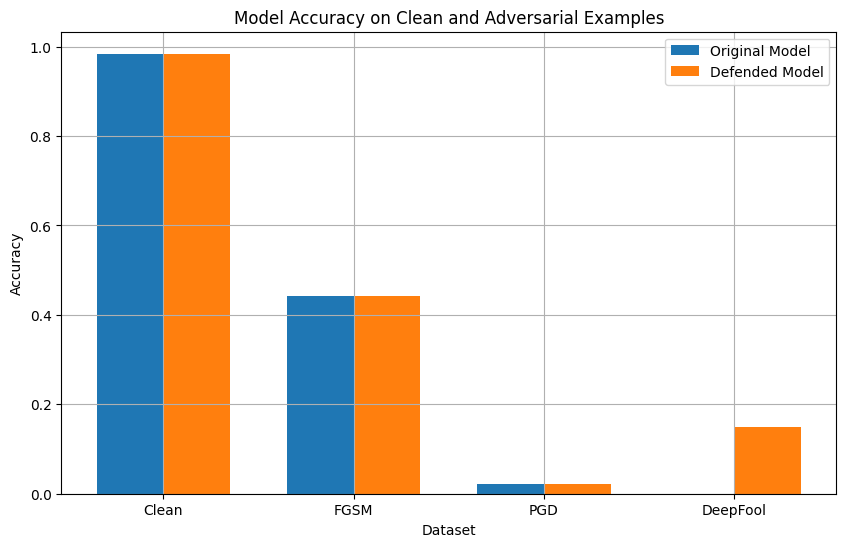

In [45]:
# Labels for each set of bars
labels = ['Clean', 'FGSM', 'PGD', 'DeepFool']

# Create the bar chart
width = 0.35
x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, original_accuracies, width, label='Original Model')
plt.bar([i + width for i in x], defended_accuracies, width, label='Defended Model')

# Add labels and titles
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Clean and Adversarial Examples')
plt.xticks([i + width / 2 for i in x], labels)
plt.legend()
plt.grid(True)
plt.show()

--------------------------------------------------------------------------------